<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-LDPC-ALIST-and-construct-the-code-parity-check-matrix-H" data-toc-modified-id="Load-LDPC-ALIST-and-construct-the-code-parity-check-matrix-H-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load LDPC ALIST and construct the code parity-check matrix H</a></span></li><li><span><a href="#Test-LDPC-encoder" data-toc-modified-id="Test-LDPC-encoder-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test LDPC encoder</a></span></li></ul></div>

<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.comm.metrics import signal_power, calcLLR, fastBERcalc
from optic.dsp.core import pnorm
from optic.comm.fec import par2gen, encodeLDPC, decodeLDPC, encoder, readAlist, encodeDVBS2
from optic.models.channels import awgn
from optic.plot import pconst
from optic.utils import parameters
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from scipy.sparse import csr_matrix, csc_matrix
from tqdm.notebook import tqdm
from numba import njit

import os.path as path
import time

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# from pathlib import Path

# pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\IEEE_802_11n_LDPC_FEC'
# #pathdir = r'C:\Users\edson\OneDrive\Documentos\GitHub\robochameleon-private\addons\AR4JA_LDPC_FEC'

# alistFolder = r'C:\Users\edson\OneDrive\Documentos\GitHub\OptiCommPy-private\optic\comm\ALIST\\'

# # Specific directory
# mat_files = list(Path(pathdir).glob('*.mat'))

# # Convert Path objects to strings if needed
# mat_files = [str(file) for file in mat_files]

# for file in mat_files:
#     d = sp.io.loadmat(file)
#     #H = csr_matrix(d['H'])
#     H = d['LDPC']['H'] # parity check matrix
#     H = H[0][0][0][0][0]
#     H = sp.sparse.csr_matrix(H)
#     filename = alistFolder + file[93:-4] + '.txt'
#     print(filename)
#     write_alist(csr_matrix.todense(H).astype(np.int8).astype(np.int8), filename)    

In [5]:
def plot_matrix(H):
    """
    Plot the binary matrix H with blue dots at positions where H[i,j] = 1.

    Parameters
    ----------
    H : ndarray of shape (m, n)
        Binary matrix.
    """
    H = np.asarray(H)
    rows, cols = np.where(H == 1)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(cols, rows, s=0.05, color='blue')  # s controls dot size
    plt.gca().invert_yaxis()
    plt.xlabel('Column indexes')
    plt.ylabel('Row indexes')
    plt.title(f'Matrix: {H.shape[0]} $\\times$ {H.shape[1]}')
    plt.axis('square')
    plt.xlim(0, H.shape[1])
    plt.ylim(H.shape[0], 0)
    plt.grid(True)
    plt.tight_layout()    
    plt.show()

## Load LDPC ALIST and construct the code parity-check matrix H

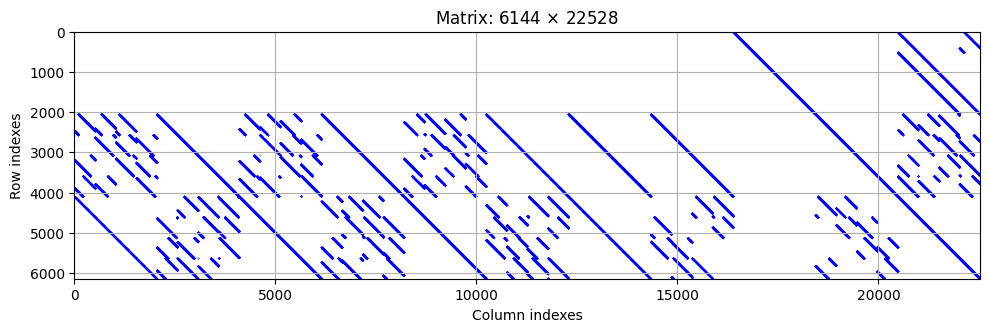

In [6]:
alistFolder = r'C:\Users\edson\OneDrive\Documentos\GitHub\OptiCommPy-private\optic\comm\ALIST'
#filename = r'\LDPC_11nD2_1944b_R56.txt'
filename = r'\LDPC_AR4JA_20480b_R45.txt'
#filename  = r'\LDPC_DVBS2_64800b_R45.txt'

H = readAlist(alistFolder+filename)
H = csr_matrix.todense(H).astype(np.int8)  
plot_matrix(H)

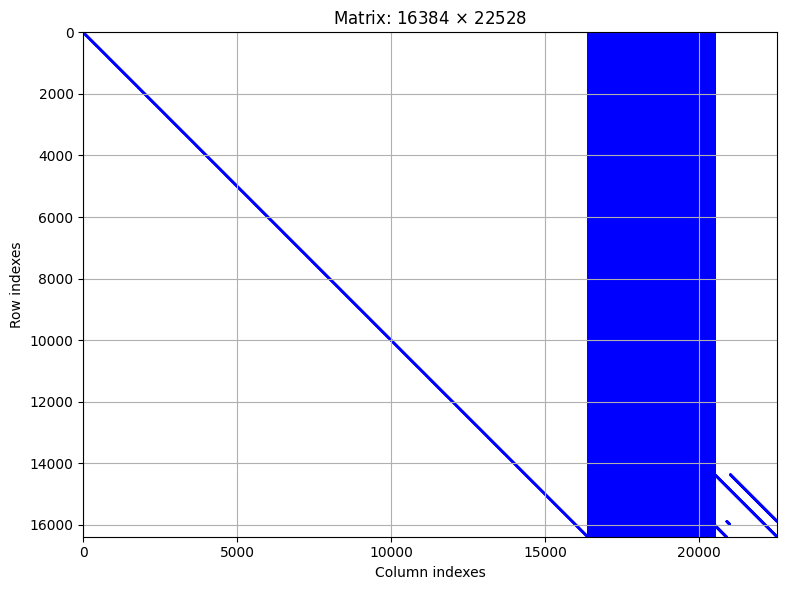

In [7]:
G, colSwaps, Hnew = par2gen(H)

revertColSwaps = np.argsort(colSwaps)
plot_matrix(G)

In [8]:
print('H :', H.shape)
print('G :', G.shape)
print('n = ', H.shape[1])
print('k = ', G.shape[0])
print('R = ', round(G.shape[0]/G.shape[1],2))

H : (6144, 22528)
G : (16384, 22528)
n =  22528
k =  16384
R =  0.73


## Test LDPC encoder

In [9]:
from optic.comm.fec import encodeLDPC

Time for encoding per codeword: 1138.22 ms


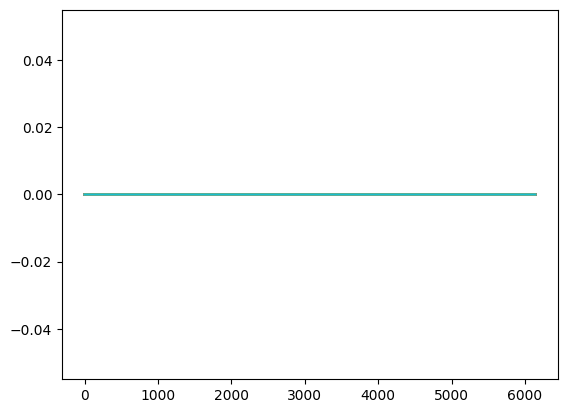

In [10]:
alistFolder = r'C:\Users\edson\OneDrive\Documentos\GitHub\OptiCommPy-private\optic\comm\ALIST'

Nwords = 20

# parameters
paramEnc = parameters()
paramEnc.mode = 'AR4JA' #'IEEE_802.11nD2'
paramEnc.n = 20480
paramEnc.R = '4/5'
paramEnc.path = alistFolder

k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

# generate random bits
bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

start = time.time()
codedbits = encodeLDPC(bits, paramEnc)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

plt.figure()
plt.plot(np.mod(paramEnc.H@codedbits,2));

Time for encoding per codeword: 236.55 ms
(22528, 20)


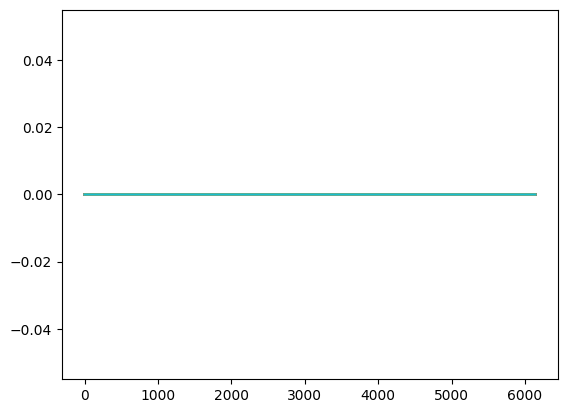

In [11]:
start = time.time()
codedbits = encodeLDPC(bits, paramEnc)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')
print(codedbits.shape)

plt.figure()
plt.plot(np.mod(paramEnc.H@codedbits,2));

Time for encoding per codeword: 480.08 ms


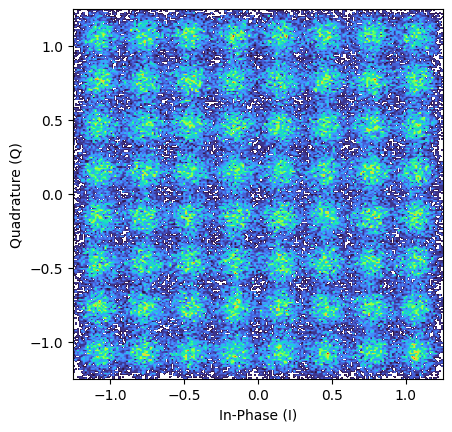

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [05:33<00:00, 27.81s/it]


Time for decoding: 350.20 s
BERpreFEC = 2.14e-02
BERpostFEC = 0.00e+00
Number of bits =  777600


In [13]:
# Run AWGN simulation 
EbN0dB = 10.5
M      = 64
Nwords = 12
nIter  = 50

# modulation parameters
constSymb = grayMapping(M,'qam')             # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# encode data bits with LDPC
# parameters
paramEnc = parameters()
paramEnc.mode = 'DVBS2' #'IEEE_802.11nD2'
paramEnc.n = 64800
paramEnc.R = '4/5'
paramEnc.path = alistFolder

k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

# generate random bits
bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

start = time.time()
codedBits = encodeLDPC(bits, paramEnc)
end = time.time()
print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

codedBitsTx = codedBits.copy().flatten()

# Map bits to constellation symbols
symbTx = modulateGray(codedBitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = pnorm(symbTx)

# AWGN    
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BERpre, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
pconst(symbRx, pType='fancy')

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
px = np.ones(M)/M
llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)

# soft-decoding
paramDec = parameters()
paramDec.H = paramEnc.H
paramDec.alg = 'MSA'
paramDec.nIter = nIter
paramDec.prgsBar = True
paramDec.prec = np.float16

start = time.time()
decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, paramDec)
end = time.time()
print(f'Time for decoding: {end-start:.2f} s')
decodedBits = (decodedBits.T).flatten()

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))

print('BERpreFEC = %.2e'%BERpre[0])
print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

In [ ]:
Nwords = 12
nIter  = 25

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [64]  # Modulation order
EbN0dB_  = np.arange(10, 11, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = grayMapping(M,'qam')             # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    
    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # encode data bits with LDPC
        # parameters
        paramEnc = parameters()
        paramEnc.mode = 'DVBS2' #'IEEE_802.11nD2'
        paramEnc.n = 64800
        paramEnc.R = '4/5'
        paramEnc.path = alistFolder

        k = (paramEnc.n*int(paramEnc.R[0]))//int(paramEnc.R[2])

        # generate random bits
        bits = np.random.randint(2, size = (k, Nwords), dtype=np.uint8)

        start = time.time()
        codedBits = encodeLDPC(bits, paramEnc)
        end = time.time()
        print(f'Time for encoding per codeword: {(end-start)/Nwords*1000:.2f} ms')

        codedBitsTx = codedBits.copy().flatten()

        # Map bits to constellation symbols
        symbTx = modulateGray(codedBitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = pnorm(symbTx)

        # AWGN    
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
       
        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        px = np.ones(M)/M
        llr = calcLLR(pnorm(symbRx), noiseVar, pnorm(constSymb), bitMap, px)
        
        # soft-decoding
        paramDec = parameters()
        paramDec.H = paramEnc.H
        paramDec.alg = 'MSA'
        paramDec.nIter = nIter
        paramDec.prgsBar = False
        paramDec.prec = np.float16

        start = time.time()
        decodedBits, llr_dec = decodeLDPC(llr.reshape(-1,codedBits.shape[1]).T, paramDec)
        end = time.time()
        print(f'Time for decoding per codeword: {(end-start)/Nwords*1000:.2f} s')
        decodedBits = (decodedBits.T).flatten()

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx.flatten(), decodedBits.flatten()))        

run sim: M =  64


  0%|          | 0/20 [00:00<?, ?it/s]

Time for encoding per codeword: 482.11 ms


In [ ]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpre[:, ii]),
        'o-',
        label=f'{str(M)}QAM monte carlo [pre]',
    )


#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpost[:, ii]),
        'kx-',
        label=f'{str(M)}QAM monte carlo [post]',
    )


plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()